In [1]:
#Imports
import numpy as np
import pandas as pd
import talib as ta
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

# Import supplementary visualization code visuals.py
import visuals as vs

In [2]:
path = "C:\\Users\\rohit\\OneDrive\\Udacity ML\\machine-learning-master\\projects\\capstone\\Stock Time Series Analysis\\"
data = pd.read_csv(path+'INFY.NS.csv',index_col=[0],parse_dates=True,dayfirst=False)

In [3]:
#Remove NA's
data.dropna(inplace=True)
print (data.tail())

              Open         High          Low        Close    Adj Close  \
Date                                                                     
2018-04-23  1168.0  1214.400024  1155.250000  1187.699951  1187.699951   
2018-04-24  1185.0  1196.400024  1150.099976  1154.500000  1154.500000   
2018-04-25  1152.0  1171.000000  1145.199951  1160.349976  1160.349976   
2018-04-26  1174.0  1181.650024  1160.000000  1176.449951  1176.449951   
2018-04-27  1180.0  1191.599976  1174.199951  1185.199951  1185.199951   

                Volume  
Date                    
2018-04-23  10915319.0  
2018-04-24   4263108.0  
2018-04-25   5797089.0  
2018-04-26   5651042.0  
2018-04-27   3831685.0  


In [4]:
#Filter only relevant columns
df = data[['Open','High','Low','Close']]

In [5]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['RSI'] = ta.RSI(np.array(df['Close']),timeperiod=10)
df['ADX'] = ta.ADX(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=7)
df['SAR'] = ta.SAR(np.array(df['High']),np.array(df['Low']),0.2,0.2)
df['Williams-R'] = ta.WILLR(df['High'].values, df['Low'].values, df['Close'].values, 7)
df.dropna(inplace=True)

df_filtered = df[['H-L','O-C','RSI','ADX','SAR','Williams-R']]

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


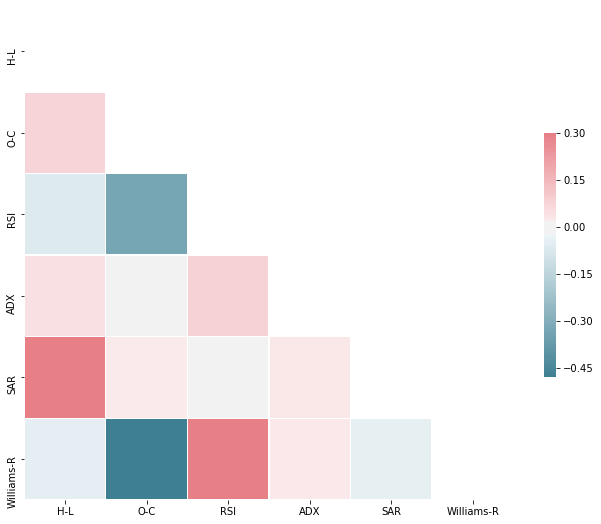

In [6]:
#Generate Correlation Matrix
corr = df_filtered.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
#Compare next day price with todays price
#If next days price greater than today then Price_change is 1 else 0
df['Price_Change'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [8]:
features = ['H-L','O-C','RSI','ADX','SAR','Williams-R']

X = df[features]
y = df['Price_Change']
len(X)

4523

In [9]:
split = int(0.8*len(df))

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3618 samples.
Testing set has 905 samples.


In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model

In [11]:
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

In [13]:
predicted = model.predict(X_test)

In [14]:
#Differenciate between up markets and down markets predictions
y_pred = (predicted > 0)

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

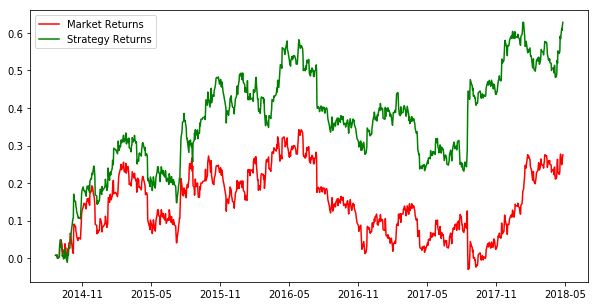

In [15]:
#Create a long short strategy
#If y_pred = True, go long, else short
import matplotlib.pyplot as plt

#Create dataframe to predict out of sample data
df['y_pred'] = np.NaN
df.iloc[(len(df) - len(y_pred)):,-1:] = y_pred
long_short_strategy = df.dropna()

#Get Next Day Returns
long_short_strategy['Tomorrows Returns'] = 0.
long_short_strategy['Tomorrows Returns'] = np.log(long_short_strategy['Close']/long_short_strategy['Close'].shift(1))
long_short_strategy['Tomorrows Returns'] = long_short_strategy['Tomorrows Returns'].shift(-1)

#If Signal is True, go Long else go Short
long_short_strategy['Strategy Returns'] = 0.
long_short_strategy['Strategy Returns'] = np.where(long_short_strategy['y_pred'] == True, long_short_strategy['Tomorrows Returns'],
                                             - long_short_strategy['Tomorrows Returns'])
#Generate cumulative returns
long_short_strategy['Cumulative Market Returns'] = np.cumsum(long_short_strategy['Tomorrows Returns'])
long_short_strategy['Cumulative Strategy Returns'] = np.cumsum(long_short_strategy['Strategy Returns'])

#Plot the data
plt.figure(figsize=(10,5))
plt.plot(long_short_strategy['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(long_short_strategy['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

In [16]:
long_short_strategy.to_clipboard()

In [17]:
pred_df = pd.DataFrame(y_pred.flatten(),index=y_test.index,columns=['Pred'])

compare_df = pd.concat([y_test,pred_df.astype(int)],join='outer',axis=1)

In [18]:
metrics.accuracy_score(y_test,y_pred)

0.49613259668508286

In [19]:
def equity_vol(rtn_series):
    '''
    daily return series
    '''
    
    vol = np.std(rtn_series)*np.sqrt(252)
    
    return vol

def equity_return(rtn_series):
    '''
    daily return series
    '''
    rtn_series.fillna(0, inplace=True)    
    
    equity_line = 100*(1+np.cumsum(rtn_series))
    
    equity_line_rtn = (equity_line.ix[-1]/100)**(252.0/(len(rtn_series)-1)) -1
    
    return equity_line_rtn

In [20]:
print (equity_vol(long_short_strategy['Strategy Returns']))
print (equity_vol(long_short_strategy['Tomorrows Returns']))

print (equity_return(long_short_strategy['Strategy Returns']))
print (equity_return(long_short_strategy['Tomorrows Returns']))

0.243721841515
0.243923603197
0.145562878533
0.0700685184488


C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [21]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0)


# The parameters list you wish to tune
parameters = {'penalty':['l1','l2'],
              'C':[0.1,0.5,1.0,2.0,]}

# Make an fbeta_score scoring object
def performance_metric(y_true, y_predict,beta=0.5):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true,y_predict)
    
    # Return the score
    return score

scorer = make_scorer(performance_metric)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=clf,param_grid=parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [22]:
best_clf

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
best_model = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
best_model = best_model.fit (X_train,y_train)
predicted = best_model.predict(X_test)

In [24]:
#Differenciate between up markets and down markets predictions
y_pred = (predicted > 0)

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

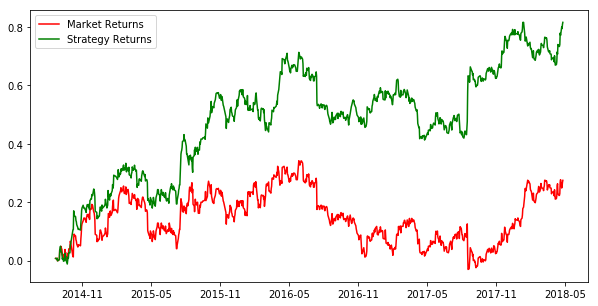

In [25]:
#Create a long short strategy
#If y_pred = True, go long, else short
import matplotlib.pyplot as plt

#Create dataframe to predict out of sample data
df['y_pred'] = np.NaN
df.iloc[(len(df) - len(y_pred)):,-1:] = y_pred
long_short_strategy = df.dropna()

#Get Next Day Returns
long_short_strategy['Tomorrows Returns'] = 0.
long_short_strategy['Tomorrows Returns'] = np.log(long_short_strategy['Close']/long_short_strategy['Close'].shift(1))
long_short_strategy['Tomorrows Returns'] = long_short_strategy['Tomorrows Returns'].shift(-1)

#If Signal is True, go Long else go Short
long_short_strategy['Strategy Returns'] = 0.
long_short_strategy['Strategy Returns'] = np.where(long_short_strategy['y_pred'] == True, long_short_strategy['Tomorrows Returns'],
                                             - long_short_strategy['Tomorrows Returns'])
#Generate cumulative returns
long_short_strategy['Cumulative Market Returns'] = np.cumsum(long_short_strategy['Tomorrows Returns'])
long_short_strategy['Cumulative Strategy Returns'] = np.cumsum(long_short_strategy['Strategy Returns'])

#Plot the data
plt.figure(figsize=(10,5))
plt.plot(long_short_strategy['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(long_short_strategy['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

# CROSS VALIDATION OVER DIFFERENT TIME PERIODS USING TIMESERIESPLIT

In [36]:
def cross_validation(X,y,s=0.2):
    
    split = int((1-s)*len(X))

    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Show the results of the split
    print ("Training set has {} samples.".format(X_train.shape[0]))
    print ("Testing set has {} samples.".format(X_test.shape[0]))
    
    best_model = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    best_model = best_model.fit (X_train,y_train)
    predicted = best_model.predict(X_test)
    
    y_pred = (predicted > 0)
    
    #Create dataframe to predict out of sample data
    df['y_pred'] = np.NaN
    df.iloc[(len(df) - len(y_pred)):,-1:] = y_pred
    long_short_strategy = df.dropna()

    #Get Next Day Returns
    long_short_strategy['Tomorrows Returns'] = 0.
    long_short_strategy['Tomorrows Returns'] = np.log(long_short_strategy['Close']/long_short_strategy['Close'].shift(1))
    long_short_strategy['Tomorrows Returns'] = long_short_strategy['Tomorrows Returns'].shift(-1)

    #If Signal is True, go Long else go Short
    long_short_strategy['Strategy Returns'] = 0.
    long_short_strategy['Strategy Returns'] = np.where(long_short_strategy['y_pred'] == True, long_short_strategy['Tomorrows Returns'],
                                             - long_short_strategy['Tomorrows Returns'])
    #Generate cumulative returns
    long_short_strategy['Cumulative Market Returns'] = np.cumsum(long_short_strategy['Tomorrows Returns'])
    long_short_strategy['Cumulative Strategy Returns'] = np.cumsum(long_short_strategy['Strategy Returns'])
    
    accuracy = metrics.accuracy_score(y_test,y_pred)
    
    returns = (equity_return(long_short_strategy['Strategy Returns']))
    vol = (equity_vol(long_short_strategy['Strategy Returns']))
    
    market_returns = (equity_return(long_short_strategy['Tomorrows Returns']))
    market_vol = (equity_vol(long_short_strategy['Tomorrows Returns']))
                  
    excess_return = returns - market_returns

    return accuracy,returns,vol,market_returns,market_vol,excess_return
    
    

In [37]:
split_sizes = [0.2,0.18,0.16,0.14,0.12,0.10,0.08,0.06,0.04,0.03,0.02,0.01]

cv_results = {}

for  ss in split_sizes:
    cv_results[ss] = cross_validation(X,y,s=ss)

Training set has 3618 samples.
Testing set has 905 samples.


C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

Training set has 3708 samples.
Testing set has 815 samples.
Training set has 3799 samples.
Testing set has 724 samples.
Training set has 3889 samples.
Testing set has 634 samples.
Training set has 3980 samples.
Testing set has 543 samples.
Training set has 4070 samples.
Testing set has 453 samples.
Training set has 4161 samples.
Testing set has 362 samples.
Training set has 4251 samples.
Testing set has 272 samples.
Training set has 4342 samples.
Testing set has 181 samples.
Training set has 4387 samples.
Testing set has 136 samples.
Training set has 4432 samples.
Testing set has 91 samples.
Training set has 4477 samples.
Testing set has 46 samples.


In [38]:
df_result = pd.DataFrame(cv_results).T
df_result.columns = ["Accuracy","Return","Volatility","Market Return","Market Volatility","Excess Return"]

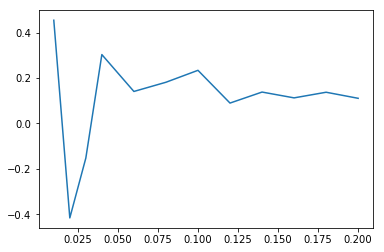

In [39]:
df_result['Excess Return'].plot()

In [40]:
df_result.to_clipboard()

In [41]:
s = df_result['Excess Return'].idxmax()
print (s)

0.01


Training set has 4477 samples.
Testing set has 46 samples.


C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

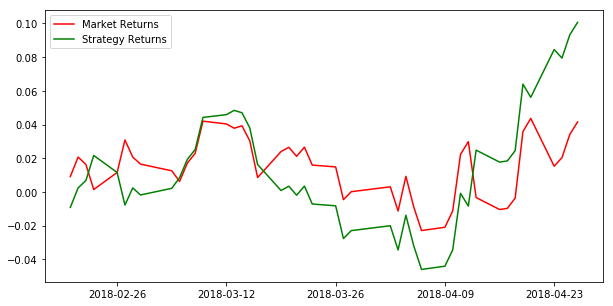

Accuracy : 0.565217391304
Returns : 0.710965411879
Volatility : 0.223350942678


In [42]:
split = int((1-s)*len(X))

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

best_model = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
      penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
      verbose=0, warm_start=False)
best_model = best_model.fit (X_train,y_train)
predicted = best_model.predict(X_test)

y_pred = (predicted > 0)

#Create dataframe to predict out of sample data
df['y_pred'] = np.NaN
df.iloc[(len(df) - len(y_pred)):,-1:] = y_pred
long_short_strategy = df.dropna()

#Get Next Day Returns
long_short_strategy['Tomorrows Returns'] = 0.
long_short_strategy['Tomorrows Returns'] = np.log(long_short_strategy['Close']/long_short_strategy['Close'].shift(1))
long_short_strategy['Tomorrows Returns'] = long_short_strategy['Tomorrows Returns'].shift(-1)

#If Signal is True, go Long else go Short
long_short_strategy['Strategy Returns'] = 0.
long_short_strategy['Strategy Returns'] = np.where(long_short_strategy['y_pred'] == True, long_short_strategy['Tomorrows Returns'],
                                         - long_short_strategy['Tomorrows Returns'])
#Generate cumulative returns
long_short_strategy['Cumulative Market Returns'] = np.cumsum(long_short_strategy['Tomorrows Returns'])
long_short_strategy['Cumulative Strategy Returns'] = np.cumsum(long_short_strategy['Strategy Returns'])

accuracy = metrics.accuracy_score(y_test,y_pred)

returns = (equity_return(long_short_strategy['Strategy Returns']))
vol = (equity_vol(long_short_strategy['Strategy Returns']))

#Plot the data
plt.figure(figsize=(10,5))
plt.plot(long_short_strategy['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(long_short_strategy['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

print ("Accuracy :", accuracy)
print ("Returns :", returns)
print ("Volatility :", vol)

In [35]:
long_short_strategy.to_clipboard()